### V.R4:  
In this version, the following functionalities have been added to V.R3:

- Generation of data for truck-to-truck collisions, including a list of points, their density, and the number of occurrences at each point.  
- Processing of added points data for other scenarios.  
- Generation of Stop Location objects for stop signs.   
- Generation of data for collisions with pedestrians and road obstacles, including added points, collision probabilities, and collision numbers.  

**Notes:**  
- Sections added in this version are marked with `#V.R4 added`. Please ensure these are included as they are.  
- Sections added in V.R3 are also highlighted. If they remain unmodified, you can continue using the corresponding code from V.R3.  
- Sections marked with `#V.R4: Modified` contain changes that were too complex to highlight individually. Please copy them exactly as presented in this version.  
- Debugging print statements have been left throughout the code for execution testing. You may remove them once the execution is complete.
- Please keep in mind that the simulation works based on simulation time in this version.


### 1. Importing All Required Libraries
<!-- Code for importing libraries will go here -->

In [1]:
# General Libraries
import pandas as pd
import numpy as np

# Libraries for creating the road network and graph
import open3d as o3d
from pyproj import Proj, Transformer
import networkx as nx  
import shapely.geometry 
from shapely.geometry import Point
import shapely
from shapely.wkt import loads

# Libraries for developing the hauling operation
import datetime as dt
import time
import simpy
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot
import opentnsim
import functools
from datetime import datetime, timedelta

# Libraries for visualisation and troubleshooting
import matplotlib.pyplot as plt
import logging

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### 2. Converting the Road Network and Location Data Files from UTM to Cartesian
<!-- Code for conversion will go here -->

In [2]:
def utm_to_latlon(utm_zone, easting, northing, altitude, precision=6):
    # Extract the UTM zone number and letter
    zone_number = int(utm_zone[:-1])
    zone_letter = utm_zone[-1]

    # Define whether the zone is in the Northern or Southern Hemisphere
    is_northern = (zone_letter >= 'N')

    # Define the UTM projection
    utm_proj = Proj(proj='utm', zone=zone_number, ellps='WGS84', south=not is_northern)

    # Define the geographic coordinate system (latitude and longitude)
    latlon_proj = Proj(proj='latlong', datum='WGS84')

    # Create a Transformer object
    transformer = Transformer.from_proj(utm_proj, latlon_proj)

    # Convert UTM to latitude and longitude
    lat, lon = transformer.transform(easting, northing)

    # Round the latitude and longitude to the specified precision
    lat = round(lat, precision)
    lon = round(lon, precision)

    # Return the latitude, longitude, and altitude
    return lat, lon, altitude


### 3. Creating the Road Network and Locations, and Creating the Network Graph
<!-- Code for creating the road network will go here -->

In [3]:
class LineNode: # This class is exactly similar to what you already have
    def __init__(self, id: int, lineset: o3d.geometry.LineSet, neighbors: set[int]):
        self.id = id
        self.lineset = lineset
        self.neighbors = neighbors

class GraphLine: 
    def __init__(self, linenodes):
        self.nodes = linenodes

    def insert_linenode(self, linenode: LineNode):
        self.nodes[linenode.id] = linenode

    def get_node(self, id: int):
        return self.nodes[id]

In [4]:
def road_layout(utm_zone):
    
    # Input file with road network points
    input_file = 'Road_network.xlsx' # if the format is in CSV, use:'Road_network.csv'
    road_points_df = pd.read_excel(input_file) # if the format is in CSV, use: pd.read_csv(input_file)

    # Apply the UTM to lat/lon conversion with rounding
    new_coords = road_points_df.apply(
        lambda row: utm_to_latlon(utm_zone, row['X'], row['Y'], row['Z']), axis=1, result_type='expand'
        )
    new_coords.columns = ['X', 'Y', 'Z']

    # Concatenate the new coordinates with the original DataFrame, dropping the old X, Y, Z columns
    road_points_df = pd.concat([road_points_df.drop(['X', 'Y', 'Z'], axis=1), new_coords], axis=1)

    # Write the result to a new Excel file
    output_file = 'road_network_latlon.xlsx' # this  file will be used for creating graph and plot. 
    road_points_df.to_excel(output_file, index=False)
    
    
    # Read the CSV file, assume first row is header
    input_file = 'road_network_latlon.xlsx'
    road_points_df = pd.read_excel(input_file, header=None)
    road_points_df = road_points_df.apply(pd.to_numeric, errors='coerce')
    
    linesets = {}

    for group_id, group in road_points_df.groupby(0):
        points = group.iloc[:, 1:].to_numpy()
        lines = [[i, i+1] for i in range(len(points)-1)]
        lineset = o3d.geometry.LineSet()
        lineset.points = o3d.utility.Vector3dVector(points)
        lineset.lines = o3d.utility.Vector2iVector(lines)
        lineset.paint_uniform_color([0, 0, 1])
        linesets[group_id] = lineset

    nodes = {}
    for x in range(1, len(linesets) + 1):
        nodes[x] = LineNode(x, linesets[x], set())

    for linenode in nodes.values():
        id = linenode.id
        lineset = linenode.lineset
        for other_id in range(1, len(linesets)+1):
            if other_id == id: continue
            if other_id in nodes[id].neighbors: continue

            points_one = np.asarray(lineset.points)
            points_two = np.asarray(linesets[other_id].points)
            for point_1_id in range(points_one.shape[0]):
                for point_2_id in range(points_two.shape[0]):
                    if np.all(np.equal(points_one[point_1_id, :], points_two[point_2_id, :])):
                        nodes[id].neighbors.add(other_id)
                        nodes[other_id].neighbors.add(id)

    graph = GraphLine(nodes) 
    return graph  

In [5]:
class LocationCLS:
    def __init__(self, name, coordinates):
        self.name = name
        self.coordinates = coordinates
        
def locations_layout(utm_zone):
    
    # Process locations for destinations and sources
    destinations_df = pd.read_csv('Destinations.csv')
    sources_df = pd.read_csv('Sources.csv')
    
    # Merge all DataFrames into one DataFrame containing all the locations
    locations_df = pd.concat([destinations_df, sources_df], ignore_index=True)
    
    # Apply the UTM to lat/lon conversion with rounding for locations
    new_loc_coords = locations_df.apply(
        lambda row: utm_to_latlon(utm_zone, row['X'], row['Y'], row['Z']), axis=1, result_type='expand'
    )
    new_loc_coords.columns = ['X', 'Y', 'Z']
    
    # Concatenate the new coordinates with the original DataFrame, dropping the old X, Y, Z columns
    locations_df = pd.concat([locations_df.drop(['X', 'Y', 'Z'], axis=1), new_loc_coords], axis=1)
    
    # Write the result to a new CSV file
    loc_output_file = 'locations_latlon.csv'
    locations_df.to_csv(loc_output_file, index=False)
    
    # Read location points from a CSV file
    location_df = pd.read_csv('locations_latlon.csv')
    
    locations = []
    for _, row in location_df.iterrows():
        name = row['Name']
        coordinates = [row['X'], row['Y']]
        locations.append(LocationCLS(name, coordinates))
    
    return locations

### 4. Creating Network X graph based on road network 
<!-- Code for truck database creation will go here -->

In [6]:
def graph_nx(graph, locations):
    G = nx.Graph()

    # Add edges between consecutive points in each lineset (connect neighborhoods)
    for linenode in graph.nodes.values():
        points = np.asarray(linenode.lineset.points)  # Get the points of the lineset

        # Connect each point to its consecutive point to create a path along the line
        for i in range(len(points) - 1):
            start_point = tuple(points[i][:2])    # Use only x, y coordinates
            end_point = tuple(points[i + 1][:2])  # Use only x, y coordinates
            G.add_edge(start_point, end_point)

    # Add locations as nodes, but only x, y coordinates (drop z)
    for location in locations:
        node_coords = tuple(location.coordinates[:2])
        G.add_node(node_coords, label=location.name)

    # ------If you dont want to plot the network x graph, remove this part ----------------    

    # Create the position dictionary for plotting all nodes in the graph
    pos = {node: node for node in G.nodes()}

    # Plot the graph using NetworkX's built-in plotting
    nx.draw(G, pos, node_color='red', with_labels=False, node_size=100, edge_color='blue')

    # Add location labels
    for location in locations:
        plt.text(location.coordinates[0], location.coordinates[1], location.name, fontsize=10, ha='left', va='bottom')

    plt.title('Road Network with Locations (Neighborhood Connections)')
    plt.grid(True)
    plt.show()
    # ------------------------------------------------------------------------------------
    return G


In [7]:
def inspect_and_fix_graph(G, distance_threshold=10):
    """
    Inspects the graph for isolated nodes and disconnected components.
    Attempts to connect isolated nodes if any are found.
    Raises an error if the graph is still disconnected after fixing.

    Parameters:
        G (nx.Graph): The input graph.
        distance_threshold (float): The maximum distance to connect isolated nodes.
    """
    def inspect_graph(G):
        """
        Inspects the graph for isolated nodes and connectivity.
        Returns the isolated nodes and number of connected components.
        """
        print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
        isolated_nodes = list(nx.isolates(G))
        print(f"Number of isolated nodes: {len(isolated_nodes)}")
        if isolated_nodes:
            print(f"Isolated nodes: {isolated_nodes}")
        else:
            print("No isolated nodes found.")

        components = list(nx.connected_components(G))
        print(f"\nGraph has {len(components)} connected components.")
        if len(components) > 1:
            print("Disconnected components detected:")
            for i, component in enumerate(components, 1):
                print(f"  Component {i}: {len(component)} nodes")
        else:
            print("Graph is fully connected.")
        
        return isolated_nodes, len(components)

    def connect_isolated_nodes(G, isolated_nodes, distance_threshold=10):
        """
        Attempts to connect isolated nodes to their nearest neighbors within a distance threshold.
        """
        pos = {node: np.array(node) for node in G.nodes()}  # Assume nodes have 2D coordinates
        
        for node in isolated_nodes:
            if node in pos:  # Ensure the node has a position
                nearest_neighbor = None
                min_distance = float('inf')

                # Check distances to all other nodes with geometry
                for other_node, other_pos in pos.items():
                    if other_node != node and other_node not in isolated_nodes:  # Avoid self and other isolated nodes
                        distance = np.linalg.norm(pos[node] - other_pos)
                        if distance < min_distance and distance <= distance_threshold:
                            nearest_neighbor = other_node
                            min_distance = distance

                # Connect the isolated node to the nearest neighbor, if found
                if nearest_neighbor:
                    G.add_edge(node, nearest_neighbor)
                    print(f"Connected isolated node {node} to {nearest_neighbor} (distance: {min_distance:.2f})")
        
        return G

    # Inspect the graph for initial status
    isolated_nodes, num_components = inspect_graph(G)

    # If isolated nodes are found, attempt to connect them
    if isolated_nodes:
        print("\nAttempting to connect isolated nodes...")
        G = connect_isolated_nodes(G, isolated_nodes, distance_threshold)

    # Reinspect the graph after attempting to fix isolated nodes
    print("\nReinspecting the graph after fixing isolated nodes...")
    isolated_nodes, num_components = inspect_graph(G)

    # Check if the graph is fully connected
    if num_components > 1:
        raise ValueError(
            f"Graph is still disconnected after fixing. "
            f"Some points may be missing in the road network. Isolated nodes: {isolated_nodes}"
        )
    else:
        print("\nGraph is now fully connected.")

    return G


**The check_connectivity_between_labels(G, labels) function is just for debugging and check, you can remove the function and related function call**

In [8]:
# this one is to make sure that all the nodes are connected and paths exsits between sources and destinations. 
def check_connectivity_between_labels(G, labels):
    # Dictionary to store connection status for each pair
    connection_status = {}

    # Iterate through each pair of labels
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            source_label = labels[i]
            target_label = labels[j]
            
            # Find nodes with the current source and target labels
            source_node = target_node = None
            for node, data in G.nodes(data=True):
                if data.get('label') == source_label:
                    source_node = node
                elif data.get('label') == target_label:
                    target_node = node
            
            # Check if both nodes exist in the graph and if there's a path between them
            if source_node and target_node:
                has_path = nx.has_path(G, source_node, target_node)
                connection_status[(source_label, target_label)] = has_path
            else:
                connection_status[(source_label, target_label)] = False

    # Print results
    for (source, target), is_connected in connection_status.items():
        connection = "Connected" if is_connected else "Not Connected"
        print(f"Path between {source} and {target}: {connection}")


**The plot_route function is just for debugging and check, you can remove the function and related function call**

In [9]:
# this one is to check and plot the a route whithi the graph
def plot_route(G, source_label, target_label):
    # Find nodes with the given labels
    source_node = None
    target_node = None
    
    for node, data in G.nodes(data=True):
        if 'label' in data:
            if data['label'] == source_label:
                source_node = node
            elif data['label'] == target_label:
                target_node = node

    # If both source and target nodes are found
    if source_node and target_node:
        # Check if there is a path between the source and target
        if nx.has_path(G, source_node, target_node):
            # Find the shortest path
            path = nx.shortest_path(G, source=source_node, target=target_node)
            print(f"Path from {source_label} to {target_label}: {path}")

            # Plot the path
            pos = {node: node for node in G.nodes()}  # Use node positions for plotting
            edge_list = list(zip(path[:-1], path[1:]))  # List of edges in the path
            
            # Draw the graph and highlight the path
            nx.draw(G, pos, node_color='red', with_labels=False, node_size=100, edge_color='blue')
            nx.draw_networkx_nodes(G, pos, nodelist=path, node_color='green', node_size=200)
            nx.draw_networkx_edges(G, pos, edgelist=edge_list, edge_color='purple', width=2)
            
            # Add labels for the source and target nodes
            plt.text(pos[source_node][0], pos[source_node][1], source_label, fontsize=10, ha='left', va='bottom')
            plt.text(pos[target_node][0], pos[target_node][1], target_label, fontsize=10, ha='left', va='bottom')
            
            plt.title(f'Route from {source_label} to {target_label}')
            plt.grid(True)
            plt.show()
        else:
            print(f"No path found between {source_label} and {target_label}")
    else:
        print("One or both nodes not found.")


In [10]:
def label_and_find_crossing_locations(G):
    crossing_locations = []
    crossing_count = 1
    
    # Iterate over each node and check if it has more than 2 edges
    for node, degree in G.degree():
        if degree > 2:
            # Label the crossing node as "Crossing1", "Crossing2", etc.
            label = G.nodes[node].get('label')
            if not label:  # If it doesn’t have an existing label, assign a crossing label
                label = f"Crossing{crossing_count}"
                G.nodes[node]['label'] = label  # Update the graph with the new label
                crossing_count += 1
            crossing_locations.append((node, label, degree))
    return G, crossing_locations

In [11]:
def plot_graph_with_labels(G):
    pos = {node: node for node in G.nodes()}  # Use node coordinates as positions

    # Draw the graph
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, node_color='red', with_labels=False, node_size=100, edge_color='blue')
    
    # Label nodes that have labels
    labeled_nodes = {node: data['label'] for node, data in G.nodes(data=True) if 'label' in data}
    nx.draw_networkx_labels(G, pos, labels=labeled_nodes, font_size=10, font_color='black')
    
    plt.title("Graph with Crossing Road Locations Labeled")
    plt.grid(True)
    plt.show()


### 5. Creating the truck database
<!-- Code for truck database creation will go here -->

In [12]:
# Create a data set fro trucks
def process_truck_data():
    # Read the CSV files
    truck_file = 'HaulageOperation_TruckDetails.csv'
    df_tr = pd.read_csv(truck_file)

    # Create an empty list to store information about each truck
    truck_list = []

    # Initialize a counter for overall truck numbering
    overall_truck_counter = 1

    # Iterate through rows and repeat based on the number of trucks
    for index, row in df_tr.iterrows():
        # Convert 'Number of trucks' to integer
        num_trucks = int(row['Number of Trucks'])
        for truck_num in range(num_trucks):
            # Create a dictionary for each truck
            truck_info = {
                'ID': row['ID'],
                'Name of the trucks': f'truck{overall_truck_counter}',
                'Type': row['Type'],
                'Payload (Ton)': row['Payload (Ton)'],
                'Minimum Speed (Mile/Hour)': row['Minimum Speed (Mile/Hour)'],
                'Maximum Speed (Mile/Hour)': row['Maximum Speed (Mile/Hour)'],
                'Unloading Time (Minute)': row['Unloading Time (Minute)'],
                'Param 1': row['Param 1'],
                'Param 2': row['Param 2']
            }
            # Increment the overall truck counter
            overall_truck_counter += 1

            # Append the truck information to the list
            truck_list.append(truck_info)

    # Calculate the total number of trucks as an integer
    total_trucks = int(df_tr['Number of Trucks'].sum())
     
    # Create a new data frame from the list
    df_tr_result = pd.DataFrame(truck_list)

    # Read the Shovel_Truck_Allocation.csv file
    allocation_file_path = 'Shovel_Truck_Allocation.csv'
    allocation_df = pd.read_csv(allocation_file_path)
   
    # Initialize an empty list to store updated allocation rows
    updated_allocation_list = []

    # Iterate through rows of allocation_df
    for allocation_index, allocation_row in allocation_df.iterrows():
        # Repeat each row based on the number of trucks
        for _ in range(allocation_row['Number of Trucks']):
            # Create a new DataFrame row with the same information as the original row
            updated_allocation_row = allocation_row.copy()
            # Append the updated allocation row to the list
            updated_allocation_list.append(updated_allocation_row)

    # Create a new DataFrame from the updated allocation list
    updated_allocation_df = pd.DataFrame(updated_allocation_list)

    # Drop the 'Number of Trucks' column
    updated_allocation_df.drop(columns=['Number of Trucks'], inplace=True)

    # Reset the index of the DataFrame to be incremental
    updated_allocation_df.reset_index(drop=True, inplace=True)
    
    # Export to CSV file
    updated_allocation_df.to_csv('updated_allocation.csv', index=False)
    # Create new 'Source' and 'Destination' columns in df_tr_result
    df_tr_result['Source'] = ''
    df_tr_result['Destination'] = ''
    
    # Copy the data frame to not be changed in the loop
    updated_allocation = updated_allocation_df.copy()

    # Iterate through rows of df_tr_result
    for index, truck_row in df_tr_result.iterrows():
        # Iterate through rows of updated_allocation_df
        for allocation_index, allocation_row in updated_allocation.iterrows():
            # Check if the text in truck_row['Type'] is contained in allocation_row['Truck Type'] (case-insensitive)
            if truck_row['Type'].lower() in allocation_row['Truck Type'].lower():
                # Assign 'Source' and 'Destination' to the corresponding columns
                df_tr_result.at[index, 'Source'] = allocation_row['Source']
                df_tr_result.at[index, 'Destination'] = allocation_row['Destination']
                # Drop the assigned row from updated_allocation_df
                updated_allocation.drop(allocation_index, inplace=True)
                # Break out of the inner loop to avoid re-assigning the same row to multiple trucks
                break
    # Export to CSV file
    df_tr_result.to_csv('truck_list.csv', index=False)
    
    return df_tr_result, updated_allocation_df, total_trucks

### 6. Creating the Hauling Activities and Simulation
<!-- Code for creating hauling activities will go here -->

In [13]:
#################################################################
#V.R4, Added: This is the function for processing added points
#################################################################

def process_added_points(added_points_data, utm_zone):
    # Step 1: Format data and handle missing 'Frequency'
    formatted_data = [
        (x, y, description, color, probability if len(point) == 5 else None)
        for point in added_points_data
        for x, y, description, color, *probability in [point]
    ]

    # Step 2: Create DataFrame
    df_added_points = pd.DataFrame(
        formatted_data,
        columns=['x', 'y', 'Type', 'Color', 'Frequency']
    )

    # Step 3: Convert x, y to Latitude, Longitude, and Shapely geometry
    def convert_to_latlon_and_geometry(row):
        lat, lon, altitude = utm_to_latlon(utm_zone, row['x'], row['y'], 0)
        geometry_point = Point(lat, lon)
        return pd.Series({'Latitude': lat, 'Longitude': lon, 'Points': geometry_point})

    df_added_points[['Latitude', 'Longitude', 'Points']] = df_added_points.apply(
        convert_to_latlon_and_geometry, axis=1
    )
    
    
    # Step 4: Create separate DataFrames for each type
    df_pedestrian_crossing = df_added_points[df_added_points['Type'] == 'Pedestrian Crossing'].reset_index(drop=True)
    df_road_obstacle = df_added_points[df_added_points['Type'] == 'Road Obstacle'].reset_index(drop=True)
    df_stop_sign = df_added_points[df_added_points['Type'] == 'Stop Sign'].reset_index(drop=True)

    return df_pedestrian_crossing, df_road_obstacle, df_stop_sign


In [14]:
##########################################################################################
# V.R4, Added: This function is to find the closest nodes on the graph to the added points
###########################################################################################

def update_dataframe_with_closest_node(df, graph, node_column_name='Closest Node'):
    """
    Updates the input DataFrame by finding and adding the closest node from the graph.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame containing a 'Points' column with Shapely geometry.
        graph (networkx.Graph): The graph with nodes containing geometries in their attributes.
        node_column_name (str): The name of the new column to store the closest nodes.
    
    Returns:
        pd.DataFrame: Updated DataFrame with the closest nodes column added.
    """
    
    # Extract graph nodes and their geometries
    graph_nodes = {node: data['geometry'] for node, data in graph.nodes(data=True)}

    # Helper function to find the closest node
    def find_closest_node(point_geom, graph_nodes):
        min_distance = float('inf')
        closest_node = None
        for node, node_geom in graph_nodes.items():
            distance = point_geom.distance(node_geom)
            if distance < min_distance:
                min_distance = distance
                closest_node = node
        return closest_node

    # Add the closest node column to the DataFrame
    df[node_column_name] = df['Points'].apply(
        lambda point_geom: find_closest_node(point_geom, graph_nodes)
    )
    
    return df

In [15]:
def wait_10s(activity, node, crossings, my_env, **kwargs):
    """
    Function to check if a node is a crossing and handle waiting logic.

    Parameters:
    - activity: The activity object (e.g., seq_activity).
    - node: The current node being checked.
    - crossings: A list of crossing objects.
    -  my_env: th environment that the simulation running on
    - **kwargs: Additional keyword arguments.
    """
    # Iterate through the crossings to check for a match
    for crossing in crossings:
        if node == crossing.geometry:  # Check if the node matches the crossing geometry
            print('waiting at crossing:', node, activity, kwargs)

            # Log the start of the waiting activity
            activity.log_entry_v1(
                t=my_env.now,
                activity_id=activity.id,
                activity_state=core.LogState.WAIT_START,
                activity_label={
                    "type": "subprocess",
                    "ref": activity.id,
                },
            )

            # Request the resource associated with the crossing
            with crossing.resource.request() as req:
                yield req
                print("requesting resource", req, my_env.now)
                yield my_env.timeout(100)

            # Log the end of the waiting activity
            print("released resource", req, my_env.now)
            activity.log_entry_v1(
                t=my_env.now,
                activity_id=activity.id,
                activity_state=core.LogState.WAIT_STOP,
                activity_label={
                    "type": "subprocess",
                    "ref": activity.id,
                },
            )
            break  # Exit the loop after handling the crossing

In [16]:
##########################################################
#V.R4, Added: This fnction is for reading the material amount
##########################################################

def read_material_handling_plan(file_path):
    try:
        # Read the CSV file
        df = pd.read_csv(file_path)

        # Ensure required columns exist
        if not {'Locations', 'Material Type', 'Quantity (Ton)'}.issubset(df.columns):
            raise ValueError("File does not contain required columns: 'Locations', 'Material Type', 'Quantity (Ton)'")

        # Convert 'Material Type' to lowercase to handle case insensitivity
        df['Material Type'] = df['Material Type'].str.lower()

        # Initialize totals with default values
        total_ore = 1000
        total_waste = 1000

        # Sum the quantities of 'ore' and 'waste' if available
        if 'ore' in df['Material Type'].values:
            total_ore = df[df['Material Type'] == 'ore']['Quantity (Ton)'].sum()
        if 'waste' in df['Material Type'].values:
            total_waste = df[df['Material Type'] == 'waste']['Quantity (Ton)'].sum()

        # Check for invalid material types
        invalid_types = df[~df['Material Type'].isin(['ore', 'waste'])]['Material Type'].unique()
        if len(invalid_types) > 0:
            raise ValueError(f"Incorrect material types found: {', '.join(invalid_types)}")

        return total_ore, total_waste

    except Exception as e:
        print(f"Error: {e}")
        return None, None


In [27]:
##########################################################################################
#V.R4, Modified: This fnction has been modified for added points and material handling plan
###########################################################################################

def run(graph, added_points_data, utm_zone): # input argumants has been modified to include graph and utm_zone
 
    # create a Site object for sources and destinations
    Site = type("Site",
                (core.Identifiable,
                 core.Log,
                 core.Locatable,
                 core.HasContainer,
                 core.HasResource,), {})

    # create a TransportProcessingResource object for trucks
    TransportProcessingResource = type(
        "TransportProcessingResource",
        (
            opentnsim.core.Movable,
            core.Identifiable,
            core.Log,
            core.HasResource,
            core.HasContainer,
            core.Processor,
            # capture extra metadata to make sure we don't have leftover arguments
            opentnsim.core.ExtraMetadata
            ),
            {},
        )
    # create a Crossing object for crossing points
    Crossing = type(
        "Crossing",
        (
            core.Identifiable,
            core.Log,
            core.Locatable,
            core.HasResource,
        ),
        {},
    )

    simulation_start = 0
    my_env = simpy.Environment(initial_time=simulation_start)

    # Call the function to get truck_list and updated_allocation_df
    truck_list, updated_allocation_df, total_trucks = process_truck_data()
    
    ##############################  This part is added to process added points ####################################
    # Call the function to get added_points data
    if added_points_data:
        df_pedestrian_crossing, df_road_obstacle, df_stop_sign = process_added_points(added_points_data, utm_zone)
    #----------------------- Debug ------------------------------------------------------------------------------#
    else:
        print("No points to process. Skipping function call.")
    #-------------------------------------------------------------------------------------------------------------#

    # Create locations dictionary
    locations = pd.read_csv('locations_latlon.csv')
    location_dict = {}
    for _, row in locations.iterrows():
        location_dict[row['Name']] = Point(row['X'], row['Y'])
        
    # Extract unique location names from the Shovel_Truck_Allocation.csv fil
    unique_locations = pd.unique(updated_allocation_df[['Source', 'Destination']].values.ravel('K'))


    ################### This part has been added to read total_ore and total_waste ####################
    file_path = 'Material_Handling_Plan_file.csv'  # Replace with the actual file path
    total_ore, total_waste = read_material_handling_plan(file_path)
    
    # ------------- Debug: Print the total_waste and total_ore ---------------------------------------
    if total_ore is not None and total_waste is not None:
        print(f"Total Ore Quantity: {total_ore} Ton")
        print(f"Total Waste Quantity: {total_waste} Ton")

    ###########--------------------------------------------------------------------------------#########
        
    # Create location objects 
    locations_data = {}
    for location_name in unique_locations:
        if location_name in location_dict:
            geometry = location_dict[location_name]
            if location_name in updated_allocation_df['Source'].values:
                capacity = total_ore * 100000
                level = total_ore * 100000
            elif location_name in updated_allocation_df['Destination'].values:
                capacity = total_waste * 100000
                level = 0
        else:
            capacity = 0
            level = 0 # Default value (this line is not necessary in this case but included for completeness)
        
        data = {
            "env": my_env,
            "name": location_name,
            "geometry": geometry,
            "capacity": capacity,
            "level": level
        }
        location_object = Site(**data)
        locations_data[location_name] = location_object

 
        
# ------------- Debug: Print the attributes of location objects -------------------------------------------            
    
    for location_name, location_object in locations_data.items():
        name = getattr(location_object, "name")
        geometry = getattr(location_object, "geometry")
        capacity = getattr(location_object, "capacity", None)
        level = getattr(location_object, "level", None)
        
        print(f"Location Name: {location_object.env}")
        print(f"Location Name: {name}")
        print(f"  Geometry: {geometry}")  # Will print the Point(x, y) if available
        print(f"  Capacity: {capacity}")
        print(f"  Level: {level}")
        print("-" * 40)
# ------------------------------------------------------------------------------------------------

    # Create a new graph with the same properties as the original
    new_graph = nx.DiGraph() if graph.is_directed() else nx.Graph()
    
    # Convert nodes to shapely.geometry.Point and preserve attributes
    node_mapping = {}
    for old_node, data in graph.nodes(data=True):
        new_node = Point(old_node[0], old_node[1])  # Convert tuple to Point
        node_mapping[old_node] = new_node
        new_graph.add_node(new_node, **data)  # Add the new node with the same attributes
    
    # Add edges, mapping old nodes to new nodes and preserving edge attributes
    for u, v, data in graph.edges(data=True):
        new_graph.add_edge(node_mapping[u], node_mapping[v], **data)
    
    for node in new_graph.nodes:
        if isinstance(node, shapely.geometry.Point):
            new_graph.nodes[node]['geometry'] = node
    
    my_env.graph = new_graph

    
    # List to store all Crossing objects
    crossing_objects = []
    
    # Iterate through the nodes in the graph
    for node, attributes in my_env.graph.nodes(data=True):
        # Check if 'label' and 'geometry' exist and if 'label' contains "Crossing"
        if 'label' in attributes and 'geometry' in attributes and "Crossing" in attributes['label']:
            # Extract label and geometry
            name = attributes['label']
            location_crossing = attributes['geometry']
            print("location crossing is", location_crossing)
            
            # Define the data_crossing dictionary
            data_crossing = {
                "env": my_env,
                "name": name, 
                "geometry": location_crossing,
                "nr_resources": 1
            }
            
            # Create Crossing object
            crossing = Crossing(**data_crossing)
            crossing_objects.append(crossing)

######################## This part is to check for added stop sign ######################
    # Process df_stop_sign if it is not empty
    if not df_stop_sign.empty:
        df_stop_sign = update_dataframe_with_closest_node(df_stop_sign, my_env.graph)

        # Iterate through the rows of df_stop_sign to create Crossing objects
        for index, row in df_stop_sign.iterrows():
            # Define name and geometry for the Crossing object
            name = f"StopSign{index + 1}"  # Generate name as StopSign1, StopSign2, etc.
            location_crossing = row['Closest Node']  # Use geometry from Closest Node
    
            # Define the data_crossing dictionary
            data_crossing = {
                "env": my_env,
                "name": name,
                "geometry": location_crossing,
                "nr_resources": 1
            }
    
            # Create the Crossing object and add it to the list
            crossing = Crossing(**data_crossing)
            crossing_objects.append(crossing)
 
        # -------------------------- Debug: Print ----------------------------------------- 
        print(f"Added {len(df_stop_sign)} Stop Sign to crossing_objects.")
    else:
        print("df_stop_sign is empty. No Stop Sign added.")
 
    # ------------- Debug: Print the content of each Crossing object ----------------------------
    for crossing in crossing_objects:
        print(vars(crossing))  # Using vars() to get the attributes of the object as a dictionary
    # -------------------------------------------------------------------------------------------
    
        
    # create truck objects
    trucks = {}

    for i in range(1, total_trucks + 1):
        # Extract information from the truck list
        truck_info = truck_list[truck_list['Name of the trucks'] == f'truck{i}'].iloc[0]
        
        # Get the source name from the truck info
        source_name = truck_info['Source']
        destination_name = truck_info['Destination']
    
        # Check if the source is in locations_data
        if source_name in locations_data and destination_name in locations_data:
            source_location = locations_data.get(source_name)
            destination_location = locations_data.get(destination_name)
        else:
            print(f"{source_name} or {destination_name} not found in locations list")
            continue
        
        source_node = source_location.geometry
        destination_node = destination_location.geometry
     
        # ------------- Debug: Print sources and destinations -----------------------------
        source_exists = source_node in my_env.graph.nodes
        destination_exists = destination_node in my_env.graph.nodes
        print(f"Source exists: {source_exists}, Destination exists: {destination_exists}")
    
        # ----------------------------------------------------------------------------------
        
        # Create an instance of TransportProcessingResource
        trucks[f"truck{i}"] = TransportProcessingResource(
            env=my_env,
            name=f"truck{i}",
            geometry=source_node,
            capacity= truck_info['Payload (Ton)'],
            v= 50, # In m/s
            route= nx.dijkstra_path(my_env.graph, source_node, destination_node)
        )  
        # ------------- Debug: Ensure no metadata exists for the instantiated truck -----------
        print(f"Metadata for truck{i}: {trucks[f'truck{i}'].metadata}")
        # -------------------------------------------------------------------------------------
        
        assert not trucks[f"truck{i}"].metadata
    
    
    # ------------- Debug: Print attributes of truck objects ----------------------------------
    for truck_name, truck in trucks.items():
        print(f"Truck Name: {truck.name}")
        print(f"Speed (v): {truck.v} units/time")
        print(f"  Geometry (Location): {truck.geometry}")
        
        print("Route:")
        for idx, location in enumerate(truck.route):
            print(f"  Step {idx + 1}: {location.x}, {location.y}")
        for node in truck.route:
            if 'geometry' not in my_env.graph.nodes[node]:
                print(f"Node {node} is missing 'geometry'")
        else:
            print(f"All nodes have geometry attributes.")
        
        print("-" * 40)  # Separator for better readability
    
    # -------------------------------------------------------------------------------------
    
    # Reading the simulation time
    # Load the CSV file
    file_path = 'Time_Frame_file.csv'  # Update with your actual file path
    time_frame = pd.read_csv(file_path)
    
    # Assuming the CSV has a column "Time Frame" and the number is in the first row
    time = time_frame.loc[0, 'Time Frame'] # It assumed to be in hour

    simulation_time = time * 3600 # Changing time to the second

    # ------------- Debug: Ensure simulation time has been extracted correctly -----------
    print(f"The simulation time is: {simulation_time}")
    # -------------------------------------------------------------------------------------
        
    
    # Defining the condition level 
    cond_level = total_waste 
    # choosing the first destination location for checking the condition level 
    destination_name = truck_list['Destination'].iloc[0]
    concept_location = locations_data.get(destination_name)
    registry = {}
    
    # Create activity objects
    # activities_d_truck = {}
    # seq_activities = []
    while_activities = []
    
    for i in range(1, total_trucks + 1):
        seq_activities = []
        truck = trucks[f"truck{i}"]
        # Get the source and destination locations for the truck
        truck_info = truck_list[truck_list['Name of the trucks'] == f'truck{i}'].iloc[0]
        source_name = truck_info['Source']
        destination_name = truck_info['Destination']
        source_location = locations_data.get(source_name)
        destination_location = locations_data.get(destination_name)
        payload = truck_info['Payload (Ton)']

        # ------------- Debug: Print locations --------------------------------------------------------
        print(source_name, source_location.geometry, destination_name, destination_location.geometry, payload)
        # ---------------------------------------------------------------------------------------------
        
        d_subprocesses = [
            model.MoveActivity(
                env=my_env,
                name=f"driving_empty:" + trucks[f"truck{i}"].name,
                registry=registry,
                mover=trucks[f"truck{i}"],
                destination=source_location,
            ),
            model.ShiftAmountActivity(
                env=my_env,
                name=f"loading:" + trucks[f"truck{i}"].name,
                registry=registry,
                processor=trucks[f"truck{i}"],
                origin=source_location,
                destination=trucks[f"truck{i}"],
                amount= payload,
                duration= 180, # In second
            ),
            model.MoveActivity(
                env=my_env,
                name=f"driving_full:" + trucks[f"truck{i}"].name,
                registry=registry,
                mover=trucks[f"truck{i}"],
                destination=destination_location,
            ),
            model.ShiftAmountActivity(
                env=my_env,
                name=f"unloading:" + trucks[f"truck{i}"].name,
                registry=registry,
                processor=trucks[f"truck{i}"],
                origin=trucks[f"truck{i}"],
                destination=destination_location,
                amount= payload,
                duration= 30,
            )
        ]

        # Create SequentialActivity for each truck
        seq_activity = model.SequentialActivity(
            sub_processes=d_subprocesses,
            registry=registry,
            name=f"Shift amount activity" + trucks[f"truck{i}"].name,
            env=my_env
        )
        
        # Attach wait function to each truck's on_pass_node_functions
        truck.on_pass_node_functions = [functools.partial(wait_10s, seq_activity, 
                                                        crossings=crossing_objects, my_env=my_env)
          ]
        
    
        # Add sequential activity to the list
        seq_activities.append(seq_activity)
        
        # Create a WhileActivity to run activities in parallel
        while_activity = model.WhileActivity(
            env=my_env,
            name=f"While activity" + trucks[f"truck{i}"].name,
            registry=registry,
            sub_processes=seq_activities,
            condition_event=[{
                "type": "container",
                "concept": concept_location,  
                "state": "gt", "level":cond_level
            }]
        )

        # Add sequential activity to the list
        while_activities.append(while_activity)

        
    processes= while_activities
    print(processes)
    model.register_processes(processes)
    try: 
        # Run the simulation for the specified simulation time
        my_env.run(until=simulation_time)
    except:
        logging.exception('run did not succeed')
    
        
    return {
        "trucks": trucks,
        #"activities_d_truck": activities_d_truck,
        "seq_activities_data": seq_activities,
        "while_activity_data": while_activity,
        "locations_data": locations_data,
        "truck_list": truck_list,
        "total_trucks": total_trucks,  
        "registry": registry,

########################### This line has been added #########################################
        "sim_graph": my_env.graph,
        "env": my_env
# ---------------------------------------------------------------------------------------------
    }

### 7. Running the Simulation and Generating Related Graphs 
<!-- Code for running the simulation and generating visualizations will go here -->

In [ ]:
#####################################################################
# V.R4, Modified: This part has been modified. Use it as it is and pay attention to the highlighted part.
#####################################################################

# Call the function to road_layout
utm_zone = "10N"
G1 = road_layout(utm_zone)
# Call the function to read lines and locations
locations = locations_layout(utm_zone)
G2 = graph_nx(G1, locations)

# Run the inspection and fixing process on the graph `G2`
try:
    G3 = inspect_and_fix_graph(G2, distance_threshold=10)
except ValueError as e:
    print(e)


# Label and find crossing locations on graph G3
G4, crossing_locations = label_and_find_crossing_locations(G3)


################# This line should be replaced by actual data input ##################################################
#Example usage: replace the following data frame with your function output: added_points_data = get_added_points ...
added_points_data = [
    (99983.8920783871, 105419.04130714286, 'Pedestrian Crossing', 'black', 0.7),
    (99767.54375725807, 105089.17121904762, 'Stop Sign', 'blue'),
    (102546.78757483872, 105081.12560714287, 'Pedestrian Crossing', 'black', 0.5),
    (102147.37528967742, 105644.3184404762, 'Road Obstacle', 'yellow', 0.9)
]
#-----------------------------------------------------------------------------------------------------------------------

res = run(G4, added_points_data, utm_zone)  # Run the hauling operation simulation, G4= is the graph that fully connected and crossings are labeled
trucks = res['trucks']
seq_activities = res['seq_activities_data']
while_activity = res['seq_activities_data']
locations_data = res['locations_data']
truck_list= res['truck_list'],
total_trucks = res['total_trucks']  # Extracting total_trucks
registry = res['registry']
G5 = res['sim_graph']
env = res ['env']
simulation_time_second = env.now
simulation_time_hours = simulation_time_second / 3600


### 8. Generating simulation data for collission assessment and visualization
<!-- Code will go here -->

In [20]:
# retriving the truck's data
def get_truck_data(truck_name, trucks, registry):
    def row2name(row):
        id = row['ActivityID']
        activity = registry["id"].get(id, None)
        if activity is None:
            return row['Message']
        # convert set to activity
        activity = list(activity)[0]
        return activity.name
        
    # Dynamically access truck object using trucks dictionary
    if truck_name in trucks:
        truck_obj = trucks[truck_name]
        truck_df = pd.DataFrame(truck_obj.logbook)
        truck_df["name"] = truck_df.apply(row2name, axis=1)
        
        return truck_df
    else:
        raise ValueError(f"Truck name {truck_name} not found in trucks dictionary.")


In [21]:
# Example usage
truck_name = 'truck1'
truck_data = get_truck_data(truck_name, trucks, registry)
truck1 = pd.DataFrame(truck_data)
truck1.head()

,Timestamp,ActivityID,ActivityState,ObjectState,ActivityLabel,Message,Value,Geometry,name
0,1970-01-01 00:00:00.000000,54f51fed-481f-4a32-862d-0a444ca8c631,START,"{'container level': 0.0, 'geometry': POINT (-1...",{},NaN,NaN,NaN,loading:truck1
1,1970-01-01 00:03:00.000000,54f51fed-481f-4a32-862d-0a444ca8c631,STOP,"{'container level': 100.0, 'geometry': POINT (...",{},NaN,NaN,NaN,loading:truck1
2,1970-01-01 01:03:00.000000,NaN,NaN,NaN,NaN,Sailing from node POINT (-126.528692 0.926502)...,0.0,POINT (-126.528692 0.926502),Sailing from node POINT (-126.528692 0.926502)...
3,1970-01-01 01:03:10.276439,NaN,NaN,NaN,NaN,Sailing from node POINT (-126.528692 0.926502)...,0.0,POINT (-126.527533 0.922004),Sailing from node POINT (-126.528692 0.926502)...
4,1970-01-01 01:03:10.276439,NaN,NaN,NaN,NaN,Sailing from node POINT (-126.527533 0.922004)...,0.0,POINT (-126.527533 0.922004),Sailing from node POINT (-126.527533 0.922004)...


### 9. Generating production chart 
<!-- Code will go here -->

In [22]:
# This function will generate step chart of production for a selected location
def plot_single_location_chart(location, truck_list):
    # Extract the DataFrame from the tuple
    truck_list_df = truck_list[0]
    
    # Get the name of the location from its .name attribute
    location_name = location.name

    # Check if the location name exists in either Source or Destination columns of the DataFrame
    if (location_name not in truck_list_df['Source'].values and
        location_name not in truck_list_df['Destination'].values):
        print(f"Location {location_name} does not exist in the truck_list.")
        return

    # Generate the plot for the single location
    fig_step = plot.get_step_chart([location])

    # If fig_step is a figure object
    if isinstance(fig_step, plt.Figure):
        ax = fig_step.gca()
    # If fig_step is an axes object
    elif isinstance(fig_step, plt.Axes):
        ax = fig_step
    else:
        raise TypeError("The output of plot.get_step_chart is neither a Figure nor an Axes object.")

    # Set title and labels
    ax.set_title(f"Transported Material to/from {location_name}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amount of Material (ton)")

    return fig_step



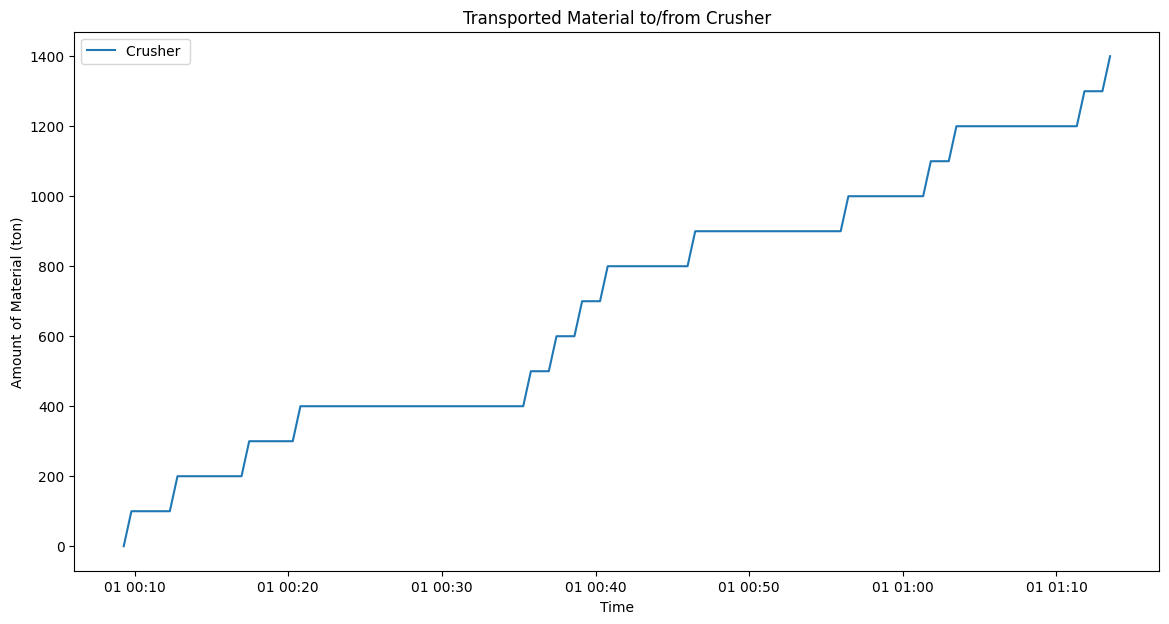

In [23]:
# Example usage
location = locations_data['Crusher']  # This should be an object with a .name attribute
fig_step = plot_single_location_chart(location, truck_list)

# Display the plot
plt.show()


In [24]:
#####################################################################################################
# V.R3: It was added in previous version and didn't change. This is the function for production chart
######################################################################################################

def analyze_transport(locations_data):
    data = []
    for location_name, location in locations_data.items():
        logbook = location.logbook # These are all the locations involved in teh hauling operation 

        # Extract the first and last container levels
        first_level = logbook[0]['ObjectState']['container level']
        last_level = logbook[-1]['ObjectState']['container level']

        # Calculate transported material
        transported_material = last_level - first_level
        data.append((location_name, transported_material))

    # Create a table
    df = pd.DataFrame(data, columns=['Location Name', 'Transported Material'])

    # Create a bar chart for transported material
    locations = [item[0] for item in data]
    transported_materials = [item[1] for item in data]

    plt.figure(figsize=(8, 6))
    plt.bar(locations, transported_materials, color='skyblue')
    plt.title('Transported Material per Location')
    plt.xlabel('Location Name')
    plt.ylabel('Transported Material (tons)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return df

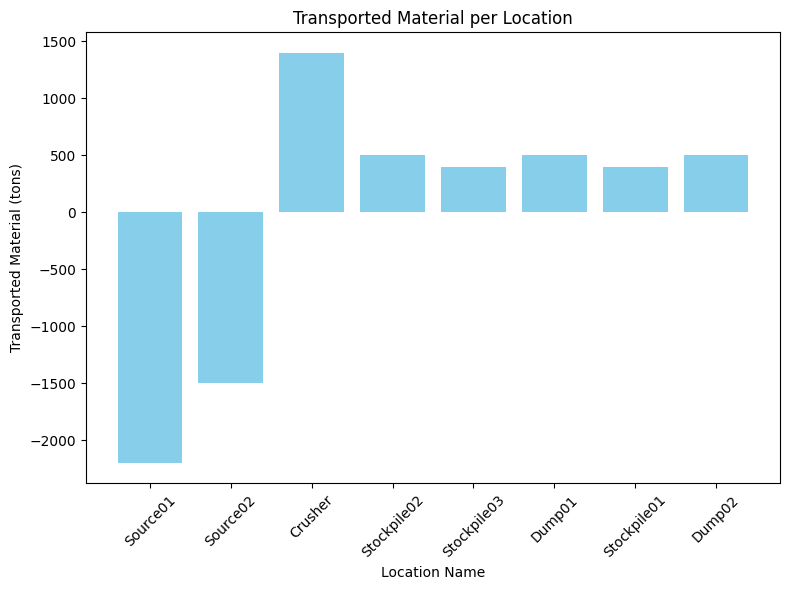


Transported Material Table:

  Location Name  Transported Material
0      Source01                 -2200
1      Source02                 -1500
2       Crusher                  1400
3   Stockpile02                   500
4   Stockpile03                   400
5        Dump01                   500
6   Stockpile01                   400
7        Dump02                   500


In [25]:
# Call the function

transported_material_df = analyze_transport(locations_data) 

# transported_material_df is the table that you need to display
print("\nTransported Material Table:\n")
print(transported_material_df)

# I only had four locations in my shovel-truck allocation, which is why only four locations are displayed here.

### 10. Generating truck density graph and truck-to-truck collission data 
<!-- Code will go here -->

In [30]:
#################################################################################
# V.R3: It was added in previous version and didn't change.
# This is the function for collecting the geometry data from truck dataframe
#################################################################################
def to_wkt(row):
    geometry = None
    # try our two methods
    try:
        geometry = row['ObjectState']['geometry']
    except (AttributeError, TypeError):
        geometry = row['Geometry'] 
    wkt = ''
    if not pd.isna(geometry):
        wkt = shapely.to_wkt(geometry, rounding_precision=8)
    return wkt

In [31]:
#################################################################
# V.R3: It was added in previous version and didn't change. 
#This is the function for generating truck density data
#################################################################

def generate_truck_geometry_data(total_trucks, trucks, registry):
    truck_data_frames = []
    timestamp_geometry_data = []

    # Process each truck
    for i in range(1, total_trucks + 1):
        truck_name = f'truck{i}'
        truck_data = get_truck_data(truck_name, trucks, registry)
        truck_df = pd.DataFrame(truck_data)
        truck_df['GeometryWkt'] = truck_df.apply(to_wkt, axis=1)

        # Extract Timestamp and Geometry columns from each truck's dataframe
        timestamp_geometry = truck_df[['Timestamp', 'GeometryWkt']]

        # Append the truck's timestamp and geometry data to the list
        timestamp_geometry_data.append(timestamp_geometry)

        # Append the complete truck dataframe to the list of truck dataframes
        truck_data_frames.append(truck_df)

    # Combine all timestamp and geometry data into a single dataframe
    timestamp_geometry_df = pd.concat(timestamp_geometry_data, ignore_index=True)

    # Optionally, combine all truck dataframes into a single dataframe
    all_trucks_df = pd.concat(truck_data_frames, ignore_index=True)

    # Create a new dataframe with the count of each geometry at the same timestamp
    geometry_counts_df = timestamp_geometry_df.groupby(['Timestamp', 'GeometryWkt']).size().reset_index(name='Count')

    return timestamp_geometry_df, geometry_counts_df


In [32]:
##############################################################
# V.R3: It was added in previous version and didn't change. 
# This is the function for truck density visualization
##############################################################

def visualize_truck_density(timestamp_geometry_df, G, distance_tolerance=0.00005):
    """
    Visualizes truck density on a graph based on proximity of points and timestamps.
    Also returns a list of points with truck counts > 1.

    Args:
        timestamp_geometry_df (pd.DataFrame): A data frame with 'Timestamp' and 'GeometryWkt'.
        G (nx.Graph): A network graph with node geometries as identifiers.
        distance_tolerance (float): Maximum distance to consider two points as overlapping.

    Returns:
        List of tuples: (node, truck_count) where truck_count > 1.
    """
    from shapely.wkt import loads
    from shapely.geometry import Point

    # Parse the timestamps and geometries
    timestamp_geometry_df['Timestamp'] = pd.to_datetime(timestamp_geometry_df['Timestamp'])
    timestamp_geometry_df['Geometry'] = timestamp_geometry_df['GeometryWkt'].apply(loads)

    # Initialize a dictionary to store truck counts per node
    node_truck_counts = {node: 0 for node in G.nodes}

    # Iterate through the nodes of G to count nearby trucks within the time range
    for node in G.nodes:
        for _, row in timestamp_geometry_df.iterrows():
            time_window_start = row['Timestamp'] - timedelta(seconds= 0.1)
            time_window_end = row['Timestamp'] + timedelta(seconds= 0.1)

            # Check if the timestamp is within the range and the geometry is close enough
            if (
                time_window_start <= row['Timestamp'] <= time_window_end
                and node.distance(row['Geometry']) <= distance_tolerance  # Use proximity check
            ):
                node_truck_counts[node] += 1

    # Prepare the list of high-count points (truck_count > 1)
    high_count_points = [(node, count) for node, count in node_truck_counts.items() if count > 1]

    # Create a DataFrame with 'Point' and 'Count' columns
    df_high_count_points = pd.DataFrame(high_count_points, columns=['Point', 'Count'])

    # Plot the graph with circle sizes proportional to truck counts
    pos = {node: (node.x, node.y) for node in G.nodes}  # Use node geometry for positions
    circle_sizes = [count * 10 for count in node_truck_counts.values()]  # Adjust scaling factor if needed
    node_labels = nx.get_node_attributes(G, 'label')  # Get node labels

    plt.figure(figsize=(12, 8))
    nx.draw(
        G,
        pos,
        with_labels=False,  # Disable default labels
        node_size=circle_sizes,
        node_color='lightblue',
        edge_color='gray',
        linewidths=0.1
        # width=5.0,  # Make edges wider
    )

    # Add labels for nodes that do NOT contain the substring 'Crossing'
    custom_labels = {node: lbl for node, lbl in node_labels.items() if 'Cross' not in lbl}
    nx.draw_networkx_labels(
        G,
        pos,
        labels=custom_labels,
        font_size=12,
        font_color='black',
    )

    plt.title('Truck Density on Network Graph', fontsize=16)
    plt.show()

    return df_high_count_points


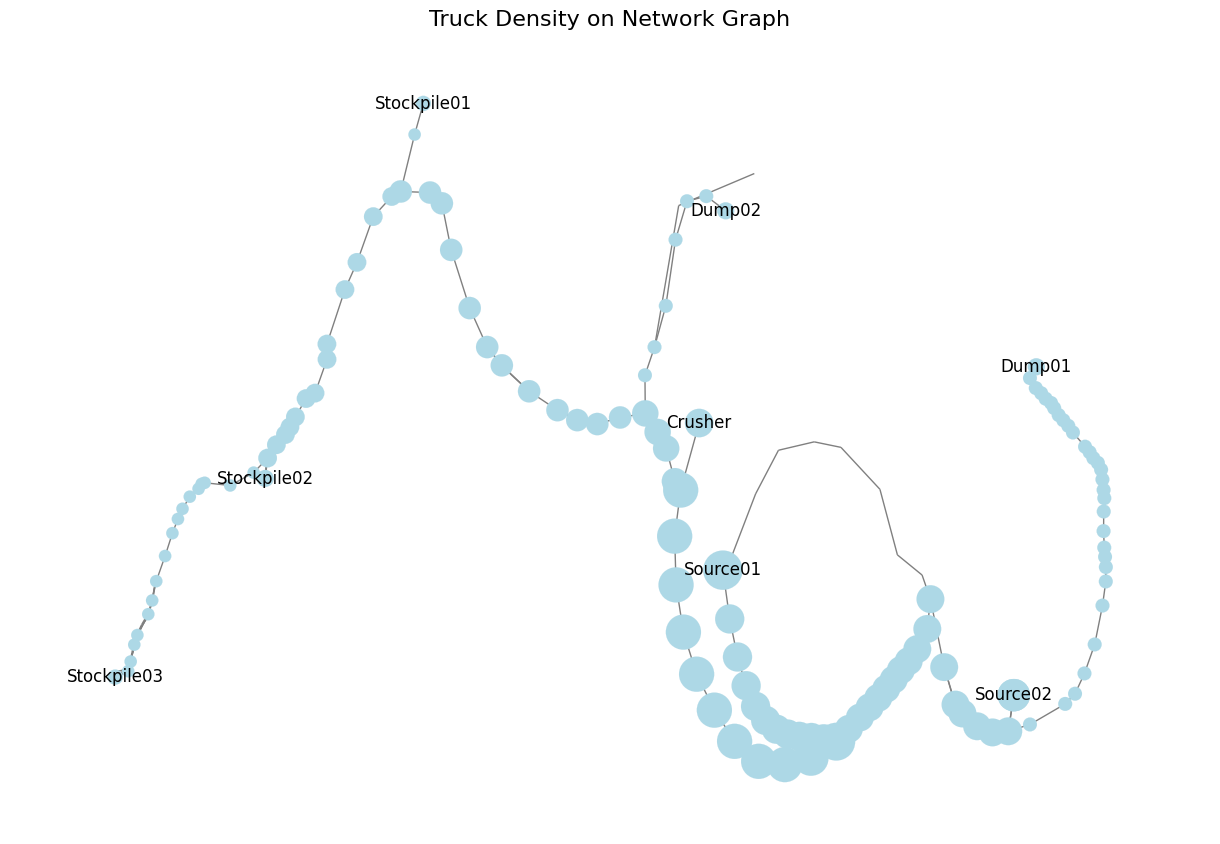

In [33]:
# Call the function to generate the required collission data
timestamp_geometry_df, geometry_counts_df = generate_truck_geometry_data(total_trucks, trucks, registry)

# Call the function to visualize the trucks collission density
truck_density_list = visualize_truck_density(timestamp_geometry_df, G5)

In [36]:
#################################################################
#V.R4, Added: This is the function for generating truck collissions data
#################################################################

def calculate_collision_data(truck_density_list, simulation_time_hours):
    """
    Calculates collision probability and collision count based on truck density data
    with proper handling of simulation time and limiting the total collision count.
    
    Args:
        truck_density_list (pd.DataFrame): Input DataFrame with columns ['Point', 'Count'].
    
    Returns:
        pd.DataFrame: DataFrame with columns ['Point', 'Truck Density', 'Collision Probability', 'Collision Number'].
    """
    # Define a year of operation in hours
    hours_per_year = 365 * 24

    # Calculate the total expected collisions based on simulation time
    total_expected_collisions = simulation_time_hours // hours_per_year

    # Scale truck density values to calculate relative probabilities
    truck_density_list['Truck Density'] = truck_density_list['Count']
    truck_density_list['Collision Probability'] = truck_density_list['Truck Density'] / truck_density_list['Truck Density'].sum()

    # Assign collision numbers such that the sum equals the total expected collisions
    truck_density_list['Collision Number'] = 0
    if total_expected_collisions > 0:
        # Sort by probability to allocate collisions to the most likely points
        sorted_indices = truck_density_list.sort_values(by='Collision Probability', ascending=False).index
        for i in range(int(total_expected_collisions)):
            truck_density_list.loc[sorted_indices[i], 'Collision Number'] = 1

    # Drop 'Count' column and keep necessary ones
    result_df = truck_density_list[['Point', 'Truck Density', 'Collision Probability', 'Collision Number']]  # This line is just for check
    collision_data_df = truck_density_list[['Point', 'Truck Density', 'Collision Number']]
    collision_points_df = collision_data_df[collision_data_df['Collision Number'] > 0]
    if collision_points_df.empty:
        print("\nNo vehicle-to-vehicle collisions occurred.")
        
    return collision_data_df, collision_points_df 


In [37]:
collision_data_df, collision_points_df  = calculate_collision_data(truck_density_list, simulation_time_hours)
print('Collission data:')
print(collision_data_df)
print('Collission point is:')
print(collision_points_df)


No vehicle-to-vehicle collisions occurred.
Collission data:
                            Point  Truck Density  Collision Number
0    POINT (-126.480267 0.911645)             48                 0
1    POINT (-126.476585 0.912274)             12                 0
2    POINT (-126.470608 0.914169)             12                 0
3    POINT (-126.468934 0.915108)             12                 0
4    POINT (-126.467337 0.916981)             12                 0
..                            ...            ...               ...
125  POINT (-126.628043 0.920516)             12                 0
126   POINT (-126.62857 0.919632)             12                 0
127  POINT (-126.629176 0.918079)             12                 0
128  POINT (-126.629593 0.917183)             12                 0
129  POINT (-126.631812 0.916642)             18                 0

[130 rows x 3 columns]
Collission point is:
Empty DataFrame
Columns: [Point, Truck Density, Collision Number]
Index: []


### 11. Generating obstacle and pedestrain collission data 
<!-- Code will go here -->

In [38]:
def check_added_ponits_collission(df_type, timestamp_geometry_df, simulation_time_hours):
    """
    Updates a DataFrame by checking and matching points with their appearance frequency using normal distribution.
    Includes debug prints for validation.
    
    Args:
        df_type (pd.DataFrame): DataFrame containing added points (Pedestrian or Road Obstacles).
        timestamp_geometry_df (pd.DataFrame): DataFrame with timestamp and geometry information.
    
    Returns:
        pd.DataFrame: Updated DataFrame with collision probability and match count.
    """
    result_rows = []
    simulation_start = datetime(1970, 1, 1, 0, 0, 0)

    for index, row in df_type.iterrows():
        point_geometry = row['Closest Node']
        frequency = row['Frequency']

        # Ensure frequency is a single float
        if isinstance(frequency, list):
            if len(frequency) > 0:
                frequency = frequency[0]  # Extract the first element
            else:
                print(f"Skipping row {index} due to empty frequency list.")
                continue
        
        if frequency is None or not isinstance(frequency, (int, float)):
            print(f"Skipping row {index} due to invalid frequency: {frequency}")
            continue

        # Find matching geometry in timestamp_geometry_df
        matched_rows = timestamp_geometry_df[timestamp_geometry_df['Geometry'] == point_geometry]

        if matched_rows.empty:
            print(f"No matching geometry found for point: {point_geometry}")
            result_rows.append({**row.to_dict(), 'Collision Probability': 0, 'Collision Match': 0})
            continue
        
        #------------------------ Print debug info ----------------------------------------#
        print(f"Found matching geometry for point: {point_geometry}")
        #----------------------------------------------------------------------------------#

        # Calculate total appearances based on frequency
        total_appearances = int(frequency * simulation_time_hours)
        timestamps = matched_rows['Timestamp'].tolist()

        # Generate normal distribution of appearance times
        if total_appearances > 0:
            appearance_times = [
                simulation_start + timedelta(seconds=int(np.random.normal(loc=i * simulation_time_hours / total_appearances,
                                                                          scale=simulation_time_hours / total_appearances)))
                for i in range(total_appearances)
            ]
        else:
            appearance_times = []

        collision_match_count = sum(1 for t in appearance_times if t in timestamps)

        #------------------------ Print debug info ----------------------------------------#
        print(f"Point: {point_geometry}")
        print(f"Frequency: {frequency}, Total Appearances: {total_appearances}")
        print(f"Collision Matches: {collision_match_count}")
        #----------------------------------------------------------------------------------#
        
        # Update row
        result_rows.append({
            **row.to_dict(),
            'Collision Probability': collision_match_count / total_appearances if total_appearances > 0 else 0,
            'Collision Match': collision_match_count
        })

    # Convert results to a DataFrame
    df_result = pd.DataFrame(result_rows)
    df_collission_data = df_result.drop(['Latitude','Longitude','Points','Closest Node'], axis=1)
    return df_collission_data


In [39]:
# Example usage
if added_points_data:
    df_pedestrian_crossing, df_road_obstacle, df_stop_sign = process_added_points(added_points_data, utm_zone)

if not df_pedestrian_crossing.empty:
    df_pedestrian_crossing_updated = update_dataframe_with_closest_node(df_pedestrian_crossing, G5)

    df_pedestrian_collission_data = check_added_ponits_collission(df_pedestrian_crossing_updated, timestamp_geometry_df, simulation_time_hours)
    print("\nPedestrian Crossing Collission Data:")
    print(df_pedestrian_collission_data)

if not df_road_obstacle.empty:
    df_road_obstacle_updated = update_dataframe_with_closest_node(df_road_obstacle, G5)

    df_obstacle_collission_data = check_added_ponits_collission(df_road_obstacle_updated, timestamp_geometry_df, simulation_time_hours)
    print("\nRoad Obstacle Collission Data:")
    print(df_obstacle_collission_data)
    


Updated DataFrame with Closest Node:
               x              y                 Type  Color Frequency  \
0   99983.892078  105419.041307  Pedestrian Crossing  black     [0.7]   
1  102546.787575  105081.125607  Pedestrian Crossing  black     [0.5]   

     Latitude  Longitude                        Points  \
0 -126.592965   0.951871  POINT (-126.592965 0.951871)   
1 -126.569972   0.948844  POINT (-126.569972 0.948844)   

                   Closest Node  
0  POINT (-126.592822 0.952375)  
1  POINT (-126.568683 0.947073)  
Found matching geometry for point: POINT (-126.592822 0.952375)
Point: POINT (-126.592822 0.952375)
Frequency: 0.7, Total Appearances: 700
Collision Matches: 0
Found matching geometry for point: POINT (-126.568683 0.947073)
Point: POINT (-126.568683 0.947073)
Frequency: 0.5, Total Appearances: 500
Collision Matches: 0

Pedestrian Crossing Collission Data:
               x              y                 Type  Color Frequency  \
0   99983.892078  105419.041307  Pe

In [42]:
df_pedestrian_collission_data

,x,y,Type,Color,Frequency,Collision Probability,Collision Match
0,99983.892078,105419.041307,Pedestrian Crossing,black,[0.7],0.0,0
1,102546.787575,105081.125607,Pedestrian Crossing,black,[0.5],0.0,0


In [41]:
df_obstacle_collission_data

,x,y,Type,Color,Frequency,Collision Probability,Collision Match
0,102147.37529,105644.31844,Road Obstacle,yellow,[0.9],0.0,0
